# Sentiment Analysis on News Headlines
Predicts positive or negative tone of the news headlines. This notebook consists of binary classifier that performs sentiment analysis on unlabelled data which used machine learning and deep learning algorithms


# Steps involved in tone prediction
- Supervised learning using scikit-learn library and NLP packages
- Deep Learning using Tensorflow and Keras

In [1]:
# # #install needed packages
# # !pip install numpy==1.21.6
# !pip install snorkel==0.9.9
# !pip install textblob==0.15.3
# # !pip install spacy==3.4.1
# # !pip install sklearn==0.0
# # !pip install sklearn-pandas==1.8.0
# # !pip install tensorboard==2.9.1


# Snorkel:
As we are dealing with unlabelled data we use snorkel module to label positive as 1 and negative as 0 for our data points

In [2]:
import numpy as np
import pandas as pd
np.seterr(all="ignore")
#Snorkel
from snorkel.labeling import LabelingFunction
import re
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import *
from snorkel.labeling import LFAnalysis
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import labeling_function



In [3]:
# !pip install srsly==2.4.3
# !pip install -U pip setuptools wheel
# !pip install -U spacy==3.2.0
# !python -m spacy download en_core_web_sm

In [4]:
#NLP packages
import spacy
from nltk.corpus import stopwords
import string
import nltk
import nltk.tokenize
punc = string.punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#Supervised learning
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
##Deep learning libraries and APIs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manapati.m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# pip install wordcloud

# 1. Load the data
The data here is retrieved from kaggle which consists of different news headlines as texts. The data has 1244184 entries

In [6]:
# store the dataset as a Pandas Dataframe
df = pd.read_csv('~/INFO7390/abcnews-date-text.csv')

In [7]:
#conduct some data cleaning
df = df.drop(['publish_date'], axis=1)
df = df.rename(columns = {'headline_text': 'text'})
df['text'] = df['text'].astype(str)



In [8]:
#check the data info
df.head()

,text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1244184 non-null  object
dtypes: object(1)
memory usage: 9.5+ MB


In [10]:

df=df[:100000]
df.shape

(100000, 1)

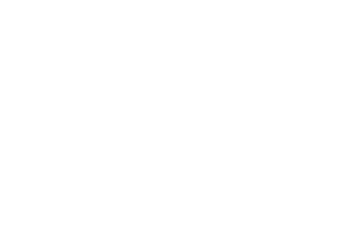

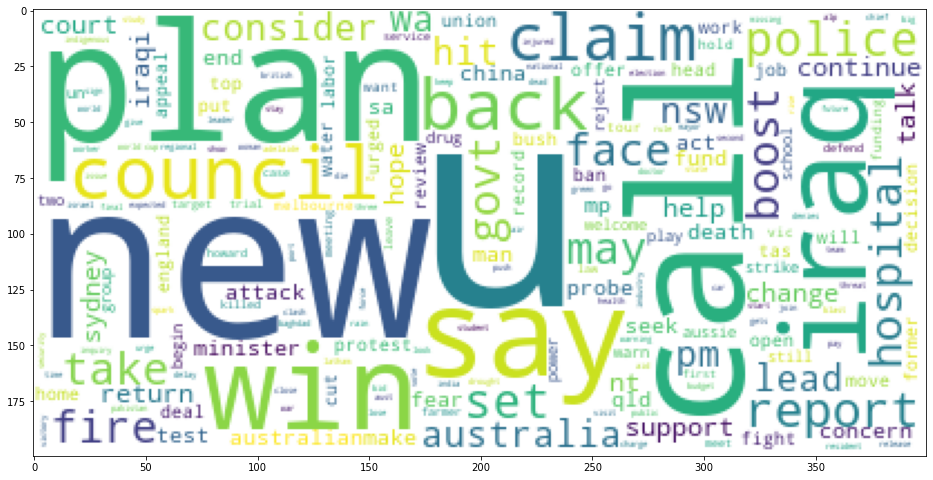

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Text from "genre" column in genres data
text_cloud = ' '.join(text for text in df.text.astype(str))

# Generate wordcloud using text
wc = WordCloud(background_color="white")
wordcloud = wc.generate(text_cloud)

# Display wordcloud
plt.axis('off')
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud)
plt.show()

# 2. Create labels using snorkel
Snorkel technique is used to label postive and negative based on the functions below which assigns the labels based on the positive and negative keywords list

In [12]:
#define constants to represent the class labels :positive, negative, and abstain
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1
#define function which looks into the input words to represent a proper label
def keyword_lookup(x, keywords, label):  
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN
#define function which assigns a correct label
def make_keyword_lf(keywords, label=POSITIVE):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label))

"""positive news might contain the following words' """
keyword_positive = make_keyword_lf(keywords=['boosts', 'great', 'develops', 'promising', 'ambitious', 'delighted', 'record', 'win', 'breakthrough', 'recover', 'achievement', 'peace', 'party', 'hope', 'flourish', 'respect', 'partnership', 'champion', 'positive', 'happy', 'bright', 'confident', 'encouraged', 'perfect', 'complete', 'assured' ,'loves'])
"""negative news might contain the following words"""
keyword_negative = make_keyword_lf(keywords=['war','solidiers', 'turmoil', 'injur','trouble', 'aggressive', 'killed', 'coup', 'evasion', 'strike', 'troops', 'dismisses', 'attacks', 'defeat', 'damage', 'dishonest', 'dead', 'fear', 'foul', 'fails', 'hostile', 'cuts', 'accusations', 'victims',  'death', 'unrest', 'fraud', 'dispute', 'destruction', 'battle', 'unhappy', 'bad', 'alarming', 'angry', 'anxious', 'dirty', 'pain', 'poison', 'unfair', 'hates','unhealthy'
                                              ], label=NEGATIVE)

<h3> In the below function we use textblob that uses predefined sentiment analyser that extracts polarity and subjective scores which is used to find postive and negative <h3>

In [13]:
#set up a preprocessor function to determine polarity & subjectivity using textlob pretrained classifier 
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x
#find polarity
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return POSITIVE if x.polarity > 0.6 else ABSTAIN
#find subjectivity 
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return POSITIVE if x.subjectivity >= 0.5 else ABSTAIN

<h3>Now we run all the data through these labelling functions where we get a count of 1's and 0's

In [14]:
#combine all the labeling functions 
lfs = [keyword_positive, keyword_negative, textblob_polarity, textblob_subjectivity ]
#apply the lfs on the dataframe
applier = PandasLFApplier(lfs=lfs)
L_snorkel = applier.apply(df=df)



100%|██████████| 100000/100000 [01:35<00:00, 1050.43it/s]


In [15]:
#apply the label model
label_model = LabelModel(cardinality=2, verbose=True)
#fit on the data
label_model.fit(L_snorkel)
#predict and create the labels
df["label"] = label_model.predict(L=L_snorkel)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.008]
INFO:root:[10 epochs]: TRAIN:[loss=0.003]
INFO:root:[20 epochs]: TRAIN:[loss=0.000]
INFO:root:[30 epochs]: TRAIN:[loss=0.000]
INFO:root:[40 epochs]: TRAIN:[loss=0.000]
INFO:root:[50 epochs]: TRAIN:[loss=0.000]
INFO:root:[60 epochs]: TRAIN:[loss=0.000]
INFO:root:[70 epochs]: TRAIN:[loss=0.000]
INFO:root:[80 epochs]: TRAIN:[loss=0.000]
INFO:root:[90 epochs]: TRAIN:[loss=0.000]
100%|██████████| 100/100 [00:00<00:00, 1086.15epoch/s]
INFO:root:Finished Training


In [16]:
#Filtering out unlabeled data points
df= df.loc[df.label.isin([0,1]), :]
#find the label counts 
df['label'].value_counts()

1    19267
0    10809
Name: label, dtype: int64

# Supervised Learning Approach:
- <h3> Logistic Regression 
- <h3> Naive Bayes Algorithm
- <h3> K-nearest Neighbor </h3>



<h3> 1. Text Pre-processing </h3>
Pre-processing is very important in NLP (Natual language processing) to prepare text data for training. It converts the raw texts to     single word of tokens 

  - Tokenising 
  - Lemmatizing
  - Removal of stop words
  - Removal of punctuations

In [17]:
#make a copy of the dataframe
data = df.copy()
from tqdm import tqdm
#define a function which handles the text preprocessing 
def preparation_text_data(data):
    """
    This pipeline prepares the text data, conducting the following steps:
    1) Tokenization
    2) Lemmatization
    4) Removal of stopwords
    5) Removal of punctuation
    """
    # initialize spacy object
    nlp = spacy.load('en_core_web_sm')
    # select raw text
    raw_text = data.text.values.tolist()
    # tokenize
    tokenized_text = [[nlp(i.lower().strip())] for i in tqdm(raw_text)]
    #define the punctuations and stop words
    punc = string.punctuation 
    #print(tokenized_text)
    stop_words = set(stopwords.words('english'))
    #lemmatize, remove stopwords and punctuationd
    corpus = []
    for doc in tqdm(tokenized_text):
        corpus.append([word.lemma_ for word in doc[0] if (word.lemma_ not in stop_words and word.lemma_ not in punc)])
    # add prepared data to df
    data["text"] = corpus
    return data
#apply the data preprocessing function
data =  preparation_text_data(data)

100%|██████████| 30076/30076 [00:01<00:00, 24016.08it/s]


<h3> 2.  Text Representation </h3>
This step involves converting data into meaningful vectors. The below function used TFIDF to assign weights to the texts that can processed for training


In [18]:
def text_representation(data):
  tfidf_vect = TfidfVectorizer()
  data['text'] = data['text'].apply(lambda text: " ".join(set(text)))
  X_tfidf = tfidf_vect.fit_transform(data['text'])
  print(X_tfidf.shape)
  #print(tfidf_vect.get_feature_names())
  X_tfidf = pd.DataFrame(X_tfidf.toarray())
  return X_tfidf
#apply the TFIDV function
X_tfidf = text_representation(data)

(30076, 13028)


In [19]:
print("test")
X= X_tfidf
y = data['label']
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


test
(30076, 13028)


In [20]:
(X_train,X_valid,y_train,y_valid) = train_test_split(X_train,y_train, train_size=0.82,random_state=1)

In [21]:
print(X_valid.shape)

(3627, 13028)


In [22]:
type(X_tfidf)
import gc
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)

Number of unreachable objects collected by GC: 13170


In [23]:
X_tfidf.to_pickle('/scratch/manapati.m/DataPreProcessed2.pkl')

In [24]:
X_tfidf = pd.read_pickle('/scratch/manapati.m/DataPreProcessedtest.pkl')

In [25]:
X_tfidf.shape

(605, 1596)

# 3. Model Training using Logistic Regression

In [26]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
 
std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression(solver='saga')
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

In [27]:
C = [1.00000000e-04, 1.45634848e-04]
penalty = ['l1', 'l2']
n_components = (1,2)
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)

In [28]:
clf_GS = GridSearchCV(pipe, parameters,verbose=2)



# Hyperparameter tuning with valid data on logistic regression

In [29]:
clf_GS.fit(X_valid, y_valid)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=1; total time=   2.5s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=1; total time=   2.4s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=1; total time=   2.4s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=1; total time=   2.5s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=1; total time=   2.4s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=2; total time=   2.4s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=2; total time=   2.6s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=2; total time=   2.3s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__penalty=l1, pca__n_components=2; total time=   2.3s
[CV] END logistic_Reg__C=0.0001, logistic_Reg__pe

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic_Reg',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'logistic_Reg__C': [0.0001, 0.000145634848],
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'pca__n_components': (1, 2)},
             verbose=2)

In [30]:
clf_GS.best_estimator_

Pipeline(steps=[('std_slc', StandardScaler()), ('pca', PCA(n_components=1)),
                ('logistic_Reg',
                 LogisticRegression(C=0.0001, penalty='l1', solver='saga'))])

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf= make_pipeline(StandardScaler(), LogisticRegression(
                      penalty='l1',solver='saga',verbose=2,n_jobs=-1,max_iter=100,random_state=42))

In [32]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 526 seconds


/home/manapati.m/.conda/envs/pythonmm39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.8min finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, penalty='l1', random_state=42,
                                    solver='saga', verbose=2))])

In [33]:
clf.score(X_test,y_test)
y_pred_log = clf.predict(X_test)

In [34]:
# #fit Log Regression Model
# print("logistisc Regression")
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# clf= make_pipeline(StandardScaler(), LogisticRegression(max_iter=500,random_state=42,solver='saga',verbose=2,n_jobs=3))
# # clf= LogisticRegression(solver='lbfgs')
# clf.fit(X_train,y_train)
# clf.score(X_test,y_test)
# y_pred_log = clf.predict(X_test)


<h3> Classification Matrix </h3>

In [35]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3542
           1       0.94      0.92      0.93      6384

    accuracy                           0.91      9926
   macro avg       0.90      0.90      0.90      9926
weighted avg       0.91      0.91      0.91      9926



In [36]:
import gc
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)

Number of unreachable objects collected by GC: 96


<h3> F1 Score </h3>

In [37]:
from sklearn.metrics import *
logf1=f1_score(y_test, y_pred_log)
print(logf1)

0.9287803335704687


<h3> Train and Test Accuracy </h3>

In [38]:
train_acc_log=clf.score(X_train,y_train)
test_acc_log=clf.score(X_test,y_test)
print ("Train accuracy ={:.2f}%".format(clf.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(clf.score(X_test,y_test)*100))

Train accuracy =99.40%
Test accuracy =90.92%


<h3> Graph for training and test accuracy </h3>


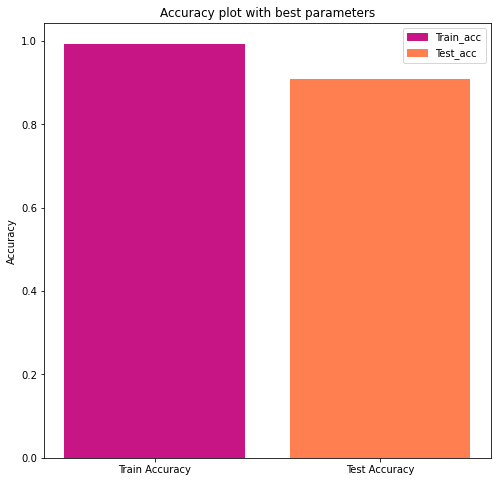

In [39]:
from math import *
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
data_log = [train_acc_log,test_acc_log]
labels = ['Train Accuracy','Test Accuracy']
plt.xticks(range(len(data_log)), labels)
plt.ylabel('Accuracy')
plt.title('Accuracy plot with best parameters')
plt.bar(range(len(data_log)), data_log,color=['mediumvioletred','coral']) 
Train_acc = mpatches.Patch(color='mediumvioletred', label='Train_acc')
Test_acc = mpatches.Patch(color='coral', label='Test_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()

<h3> Prediction on new data </h3> 

In [40]:
new_data = ["The US imposes sanctions on Russia because of the Ukranian war"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
logistic_prediction = clf.predict(new_data)
print(logistic_prediction)

[0]


In [41]:
new_data = ["3 people dead, 39 homes damaged after house explosion in Indiana"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
logistic_prediction = clf.predict(new_data)
print(logistic_prediction)

[0]


In [42]:
new_data = ["The economy of the country is increasing "]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
logistic_prediction = clf.predict(new_data)
print(logistic_prediction)

[1]


In [43]:
new_data = ["There was a huge distribution of the sweets to the orphans"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
logistic_prediction = clf.predict(new_data)
print(logistic_prediction)

[1]


# Model Training using Naive Bayes Algorithm:
Naive Bayes : This is a probabilistic machine learning model based on the Bayes theorem that’s used for classification tasks. It uses assumption of conditional independence between every pair of features given the value of the class variable, i.e., it provides a relationship between a class variable and dependent feature vectors. To also state there is another assumption made that all the predictors have an equal effect on the outcome.

- In this case, the complement Naive Bayes function is employed to rectify the assumptions made by the normal multinomial classifier.  For unbalanced datasets, the Naive Bayes function is ideal.


In [44]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics



In [45]:
param_grid = {
    "alpha": [10, 100, 1000, 500],
    
}



In [46]:
cnb = ComplementNB()
grid_search = GridSearchCV(cnb, param_grid, verbose=2)


# Hyperparameter tuning with valid data on naive bayes

In [47]:
grid_search.fit(X_valid, y_valid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........................................alpha=10; total time=   0.6s
[CV] END ...........................................alpha=10; total time=   0.5s
[CV] END ...........................................alpha=10; total time=   0.5s
[CV] END ...........................................alpha=10; total time=   0.5s
[CV] END ...........................................alpha=10; total time=   0.5s
[CV] END ..........................................alpha=100; total time=   0.5s
[CV] END ..........................................alpha=100; total time=   0.5s
[CV] END ..........................................alpha=100; total time=   0.5s
[CV] END ..........................................alpha=100; total time=   0.6s
[CV] END ..........................................alpha=100; total time=   0.5s
[CV] END .........................................alpha=1000; total time=   0.5s
[CV] END ........................................

GridSearchCV(estimator=ComplementNB(),
             param_grid={'alpha': [10, 100, 1000, 500]}, verbose=2)

In [48]:
grid_search.best_params_

{'alpha': 500}

In [49]:
cnb

ComplementNB()

In [50]:
cnb = ComplementNB(alpha=500)


In [51]:
cnb.fit(X_train, y_train)

ComplementNB(alpha=500)

<h3> Classification Matrix: </h3>

In [52]:
y_pred_cnb = cnb.predict(X_test)
print(classification_report(y_test, y_pred_cnb))


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3542
           1       0.91      0.92      0.91      6384

    accuracy                           0.89      9926
   macro avg       0.88      0.88      0.88      9926
weighted avg       0.89      0.89      0.89      9926



<h3> F1 score

In [53]:

cnbf1=f1_score(y_test, y_pred_cnb)
print(cnbf1)

0.9135397123202001


<h3> Training and test accuracy </h3>

In [54]:
# cross_cnb = cross_val_score(cnb, X, y)
# print("Cross Validation score = ",cross_cnb)                
print ("Train accuracy ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

Train accuracy =89.71%
Test accuracy =88.86%


<h3> Graph for training and test accuracy </h3>

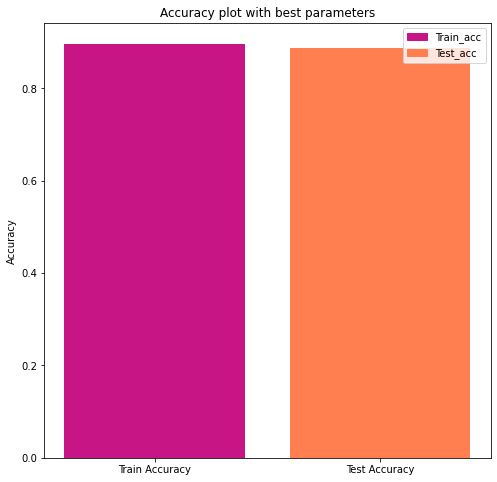

In [55]:
data_cnb = [train_acc_cnb,test_acc_cnb]
labels = ['Train Accuracy','Test Accuracy']
plt.xticks(range(len(data_cnb)), labels)
plt.ylabel('Accuracy')
plt.title('Accuracy plot with best parameters')
plt.bar(range(len(data_cnb)), data_cnb,color=['mediumvioletred','coral']) 
Train_acc = mpatches.Patch(color='mediumvioletred', label='Train_acc')
Test_acc = mpatches.Patch(color='coral', label='Test_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()


<h3> Predict on new headlines </h3>

In [56]:
new_data = ["The US imposes sanctions on Rassia because of the Ukranian war"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
cnb_prediction = cnb.predict(new_data)
print(cnb_prediction)

[0]


In [57]:
new_data = ["3 people dead, 39 homes damaged after house explosion in Indiana"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
cnb_prediction = cnb.predict(new_data)
print(cnb_prediction)

[0]


In [58]:
new_data = ["The economy of the country is increasing rapidly which shows great growth in the country"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
cnb_prediction = cnb.predict(new_data)
print(cnb_prediction)

[1]


In [59]:
new_data = ["There was a huge distribution of the sweets to the orphans"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
cnb_prediction = cnb.predict(new_data)
print(cnb_prediction)

[1]


# Model training using K- nearest neighbor
KNN is widely used for classification problems. For this problem we compare the euclidean distance from the test data to all the training data points. For classification, class label of the nearest point is assigned to the new test data.

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,2))
n_neighbors = list(range(1,2))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier(n_jobs=-1)

# modelknn = KNeighborsClassifier(n_neighbors=3,n_jobs=3)

# Hyperparameter tuning with valid data on knn

In [61]:
#Use GridSearch
modelknn = GridSearchCV(knn_2, hyperparameters, cv=2, verbose = True)

In [62]:
modelknn.fit(X_valid, y_valid)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'leaf_size': [1], 'n_neighbors': [1], 'p': [1, 2]},
             verbose=True)

In [63]:
#Print The value of best Hyperparameters
print('Best leaf_size:', modelknn.best_estimator_.get_params()['leaf_size'])
print('Best p:', modelknn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', modelknn.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


In [64]:
modelknnhp = KNeighborsClassifier(leaf_size=modelknn.best_estimator_.get_params()['leaf_size'], n_neighbors=modelknn.best_estimator_.get_params()['n_neighbors'], p=modelknn.best_estimator_.get_params()['p'],n_jobs=-1)

In [65]:
modelknnhp

KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1)

In [66]:
modelknnhp.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_jobs=-1, n_neighbors=1, p=1)

In [67]:
# pred_test = modelknn.predict(X_test) 
train_pred = modelknn.predict(X_train)

<h3> Confusion Matrix </h3>

In [68]:
y_pred_knn = modelknn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      3542
           1       0.83      0.81      0.82      6384

    accuracy                           0.77      9926
   macro avg       0.75      0.76      0.75      9926
weighted avg       0.77      0.77      0.77      9926



<h3> F1 Score 

In [69]:
from sklearn.metrics import *
knnf1=f1_score(y_test, y_pred_knn)
print(knnf1)

0.8191006764822921


<h3> Train and Test Accuracy </h3>

In [70]:
train_acc_knn=modelknn.score(X_train,y_train)
test_acc_knn=modelknn.score(X_test,y_test)
print ("Train accuracy ={:.2f}%".format(train_acc_knn*100))
print ("Test accuracy ={:.2f}%".format(test_acc_knn*100))

Train accuracy =76.93%
Test accuracy =77.10%


<h3> Graph for training and test accuracy </h3>

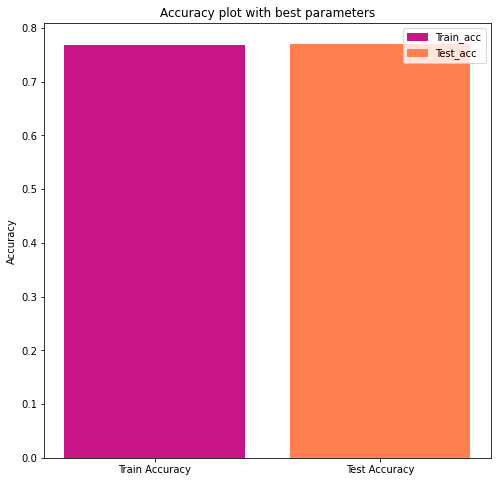

In [71]:
from math import *
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
data_knn = [train_acc_knn,test_acc_knn]
labels = ['Train Accuracy','Test Accuracy']
plt.xticks(range(len(data_knn)), labels)
plt.ylabel('Accuracy')
plt.title('Accuracy plot with best parameters')
plt.bar(range(len(data_knn)), data_knn,color=['mediumvioletred','coral']) 
Train_acc = mpatches.Patch(color='mediumvioletred', label='Train_acc')
Test_acc = mpatches.Patch(color='coral', label='Test_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()

<h3> Predict on new instances </h3?

In [72]:
new_data = ["The US imposes sanctions on Rassia because of the Ukranian war"]
# new_data = ["Adhrusta hates to cook and hates to eat food more"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
knn = modelknn.predict(new_data)
print(knn)

[0]


In [73]:
new_data = ["There was a huge distribution of the sweets to the orphans"]
tf = TfidfVectorizer()
tfdf = tf.fit_transform(data['text'])
vect = pd.DataFrame(tf.transform(new_data).toarray())
new_data = pd.DataFrame(vect)
knn = modelknn.predict(new_data)
print(knn)

[1]


# Deep Learning Approach : Tensorflow and Keras
Tensorflow to preprocess the data using tokeniser class. Keras to load and train sequential model where each layer has exactly one input and output tensor


In [74]:
##store headlines and labels in respective lists
text = list(df['text'])
labels = list(df['label'])
df.shape

(30076, 2)

<h3> Train and test split </h3>

In [75]:
##sentences
training_text = text[0:20000]
testing_text = text[20000:]
##labels
training_labels = labels[0:20000]
testing_labels = labels[20000:]

In [76]:
!pip install keras==2.8.0
# !pip install tensorflow==2.8.2
df.shape
import tensorflow as tf

In [77]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<h3> Set up the tokenizer from Tensor to pre-process the data </h3>

In [78]:
#preprocess 
tokenizer = Tokenizer(num_words=15000, oov_token= "<OOV>")
tokenizer.fit_on_texts(training_text)
word_index = tokenizer.word_index


In [79]:
training_sequences = tokenizer.texts_to_sequences(training_text)
training_padded = pad_sequences(training_sequences, maxlen=120, padding='post', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(testing_text)
testing_padded = pad_sequences(testing_sequences, maxlen=120, padding='post', truncating='post')


In [80]:
# convert lists into numpy arrays to make it work with TensorFlow 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

<h3> Define & train the Sequential model </h3> 

In [93]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(15000, 16, input_length=120),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           240000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 240,433
Trainable params: 240,433
Non-trainable params: 0
_________________________________________________________________


In [94]:
num_epochs = 10
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/10
625/625 - 2s - loss: 0.6465 - accuracy: 0.6421 - val_loss: 0.6315 - val_accuracy: 0.6377 - 2s/epoch - 3ms/step
Epoch 2/10
625/625 - 1s - loss: 0.5052 - accuracy: 0.7438 - val_loss: 0.3559 - val_accuracy: 0.9045 - 1s/epoch - 2ms/step
Epoch 3/10
625/625 - 1s - loss: 0.2223 - accuracy: 0.9322 - val_loss: 0.1921 - val_accuracy: 0.9317 - 1s/epoch - 2ms/step
Epoch 4/10
625/625 - 1s - loss: 0.1220 - accuracy: 0.9636 - val_loss: 0.1521 - val_accuracy: 0.9483 - 1s/epoch - 2ms/step
Epoch 5/10
625/625 - 1s - loss: 0.0825 - accuracy: 0.9746 - val_loss: 0.1221 - val_accuracy: 0.9556 - 1s/epoch - 2ms/step
Epoch 6/10
625/625 - 1s - loss: 0.0609 - accuracy: 0.9824 - val_loss: 0.1010 - val_accuracy: 0.9638 - 1s/epoch - 2ms/step
Epoch 7/10
625/625 - 1s - loss: 0.0462 - accuracy: 0.9868 - val_loss: 0.0935 - val_accuracy: 0.9664 - 1s/epoch - 2ms/step
Epoch 8/10
625/625 - 1s - loss: 0.0354 - accuracy: 0.9905 - val_loss: 0.0894 - val_accuracy: 0.9679 - 1s/epoch - 2ms/step
Epoch 9/10
625/625 - 1s 

<h3> Predict on new instance </h3>

In [95]:
new_headline = ["The US imposes sanctions on Rassia because of the Ukranian war"]
sequences = tokenizer.texts_to_sequences(new_headline)
padded_seqs = pad_sequences(sequences, maxlen=120, padding='post', truncating='post')
print(model.predict(padded_seqs))

[[0.14511375]]


In [96]:
new_data = ["3 people dead, 39 homes damaged after house explosion in Indiana"]
sequences = tokenizer.texts_to_sequences(new_data)
padded_seqs = pad_sequences(sequences, maxlen=120, padding='post', truncating='post')
print(model.predict(padded_seqs))

[[0.00092784]]


In [97]:
new_data = ["There was a huge distribution of the sweets to the orphans"]
sequences = tokenizer.texts_to_sequences(new_data)
padded_seqs = pad_sequences(sequences, maxlen=120, padding='post', truncating='post')
print(model.predict(padded_seqs))

[[0.99951005]]


<h3> Classification Matrix and f1 score </h3>

In [98]:
y_pred_deep = model.predict(testing_padded)
for i in range(y_pred_deep.shape[0]):
 if y_pred_deep[i]>0.5:
    y_pred_deep[i] = 1
    # print("1")
 else:
    # print("0")
    y_pred_deep[i] = 0
# print(y_pred_deep)
# print(testing_labels)
print(classification_report(testing_labels, y_pred_deep))

from sklearn.metrics import *
deepf1=f1_score(testing_labels, y_pred_deep)
print(deepf1)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3651
           1       0.98      0.98      0.98      6425

    accuracy                           0.97     10076
   macro avg       0.97      0.97      0.97     10076
weighted avg       0.97      0.97      0.97     10076

0.9757122839794489


<h3> Training and test accuracy  </h3>

In [99]:

eval_result_test = model.evaluate(testing_padded, testing_labels)
eval_result_train = model.evaluate(training_padded, training_labels)
print("[test loss, test accuracy]:", eval_result_test)

print("[train loss, train accuracy]:", eval_result_train)

625/625 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9965
[test loss, test accuracy]: [0.0833088606595993, 0.9690353274345398]
[train loss, train accuracy]: [0.0158280860632658, 0.9965000152587891]


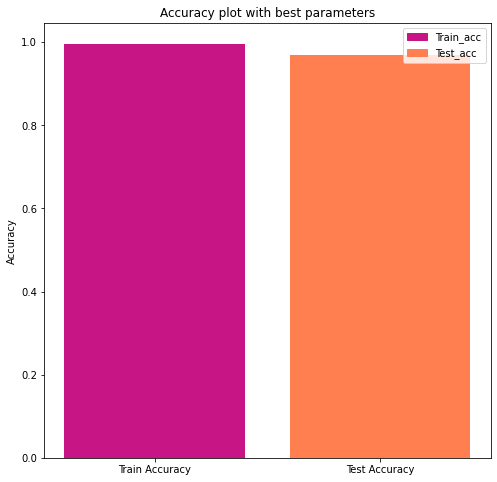

In [100]:
data_deep = [eval_result_train[1],eval_result_test[1]]
labels = ['Train Accuracy','Test Accuracy']
plt.xticks(range(len(data_deep)), labels)
plt.ylabel('Accuracy')
plt.title('Accuracy plot with best parameters')
plt.bar(range(len(data_deep)), data_deep,color=['mediumvioletred','coral']) 
Train_acc = mpatches.Patch(color='mediumvioletred', label='Train_acc')
Test_acc = mpatches.Patch(color='coral', label='Test_acc')
plt.legend(handles=[Train_acc, Test_acc],loc='best')
plt.gcf().set_size_inches(8, 8)
plt.show()

# comparing test and train accuracy of all methods 

In [101]:
Train_acc=[train_acc_log,train_acc_cnb,train_acc_knn,eval_result_train[1]]
Test_acc=[test_acc_log,test_acc_cnb,test_acc_knn,eval_result_test[1]]
print(Train_acc)
print(Test_acc)


[0.9940083519941899, 0.8970525933547177, 0.7692912909277976, 0.9965000152587891]
[0.9092282893411243, 0.8885754583921015, 0.7710054402579085, 0.9690353274345398]


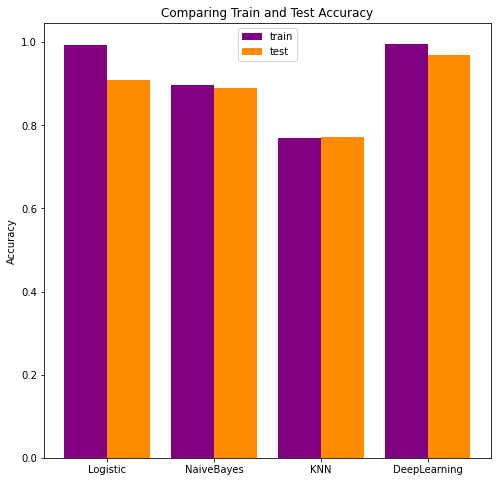

In [102]:
# Import Library

import numpy as np 
import matplotlib.pyplot as plt 

# Define Data

Algorithms = ['Logistic','NaiveBayes','KNN','DeepLearning']


x_axis = np.arange(len(Algorithms))

# Multi bar Chart

plt.bar(x_axis -0.2, Train_acc, width=0.4, label = 'train',color='purple')
plt.bar(x_axis +0.2, Test_acc, width=0.4, label = 'test',color='darkorange')

# Xticks

plt.xticks(x_axis, Algorithms)
plt.ylabel('Accuracy')
plt.title('Comparing Train and Test Accuracy')
# Add legend
plt.gcf().set_size_inches(8, 8)
plt.legend()

# Display

plt.show()

In [103]:
f1score=[logf1,cnbf1,knnf1,deepf1]
print(f1score)

[0.9287803335704687, 0.9135397123202001, 0.8191006764822921, 0.9757122839794489]


# Comparing F1 Score for all algorithms

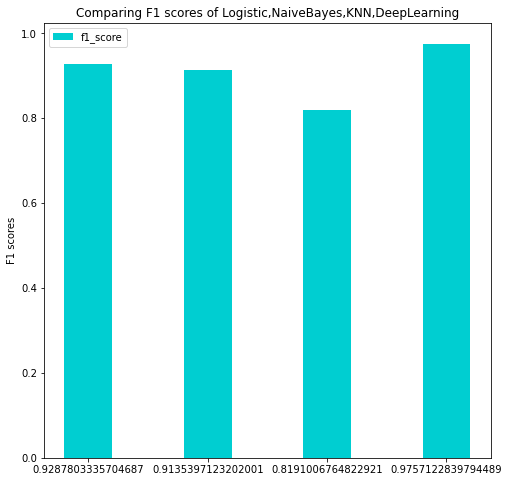

In [104]:
Algorithms = ['Logistic','NaiveBayes','KNN','DeepLearning']

# f1score=[logf1,cnbf1,knnf1,deepf1]
x_axis = np.arange(len(f1score))

# Multi bar Chart

plt.bar(x_axis, f1score, width=0.4, label = 'f1_score',color='darkturquoise')
plt.xticks(x_axis, f1score)
# plt.xticks(x_axis, Algorithms)
plt.ylabel('F1 scores')
plt.title('Comparing F1 scores of Logistic,NaiveBayes,KNN,DeepLearning')
# Add legend
plt.gcf().set_size_inches(8, 8)
plt.legend()

# Display

plt.show()

# Conclusion
- Logistic Regression:
Accuracy: 90.92%
F1 Score: 0.92
-Naive Bayes : 
Accuracy: 88.86%
F1 Score: 0.91
-KNN: 
Accuracy: 77.10%
F1 Score: 0.81
-Deep Learning:
Accuracy: 96%
F1 Score: 0.97

- F1 Score which is greater than 0.7 is considered as a fairly to good model. In that case out of all the models in supervised learning Logistic regression is considered as a good model and deep learning as fairly good model. 
- We need to consider that the training of the model happened on the headline of the news and it is very good in capturing the sentiment of the news headlines rather than normal sentences.
- We can conclude that by considering accuracies and f1 score, Logistic regression and Deep learning using keras has highest impact and is most effective in sentiment analysis of News Headlines. 
- KNN has the least effect on sentiment analysis compared to all the other algorithms

# References
- https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
- https://randerson112358.medium.com/stock-market-sentiment-analysis-using-python-machine-learning-5b644f151a3e
- https://towardsdatascience.com/sentiment-analysis-on-news-headlines-classic-supervised-learning-vs-deep-learning-approach-831ac698e276
- https://pub.towardsai.net/actually-you-need-all-3-for-1-outcome-nlp-sentiment-analysis-with-vader-textblob-and-flair-51226744a05e
- https://blog.datazar.com/first-debate-2016-sentimental-analysis-of-candidates-58d87092fc6a
- https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html